In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sb
import random
from collections import defaultdict

%matplotlib inline

# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *Y*

**Names:**

* *Kristian Aurlien*
* *Mateusz Paluchowski*

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [2]:
components_G = nx.read_adjlist("../data/components.graph", create_using=nx.DiGraph())

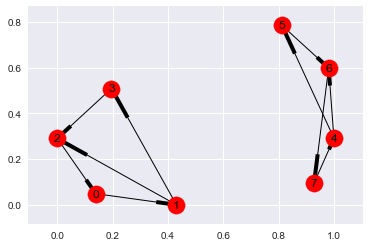

In [3]:
nx.draw_networkx(components_G, arrows=True)
plt.show() 

In [4]:
absorbing_G = nx.read_adjlist("../data/absorbing.graph", create_using=nx.DiGraph())

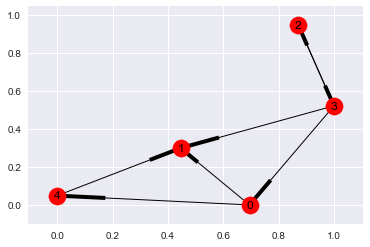

In [5]:
nx.draw_networkx(absorbing_G)
plt.show() 

It is clear that naive random surfer will fail in both of the examples.

For components graph it will discover only one of two separate components, and for absorbing graph it will eventually get stuck in node 1 of the graph, since it is a dangling node.

Anyway lets implement this naive random walker:

In [6]:
def naive_random_surfer(G, hops=1000):
    visits = defaultdict(int)
    
    node = random.choice(G.nodes())
    for _ in range(hops):
        visits[node] += 1
        
        try:
            node = random.choice(G.neighbors(node))
        except:
            pass
        
    for key in sorted(visits):
        print("{}: {}".format(key, visits[key]))

In [7]:
naive_random_surfer(components_G, 1000)

0: 288
1: 287
2: 288
3: 137


In [8]:
naive_random_surfer(absorbing_G, 1000)

0: 1
1: 998
3: 1


#### Exercise 2.13

In [9]:
DAMPING_FACTOR = 0.15

def page_rank(G, hops=1000):
    visits = defaultdict(int)
    
    node = random.choice(G.nodes())
    for _ in range(hops):
        visits[node] += 1
        
        if random.random() > DAMPING_FACTOR:
            neighbors = G.neighbors(node)
            if neighbors:
                node = random.choice(G.neighbors(node))
            else:
                node = random.choice(G.nodes())
        else:
            node = random.choice(G.nodes())
        
    for key in sorted(visits) :
        print("{}: {}".format(key, visits[key]))


In [10]:
page_rank(components_G, 10000)

0: 1429
1: 1422
2: 1468
3: 772
4: 1374
5: 752
6: 1406
7: 1377


In [11]:
page_rank(absorbing_G, 10000)

0: 1503
1: 3418
2: 1473
3: 2139
4: 1467


Improved PageRank random surfer works significantly better than naive implementation. No we can actually see that for components graph node connectivity is more or less uniform just as one would expect, and both components are explored not just one. Nodes with few in-edges get lower score, and if a node has an in-edge only from nodes with many out-edges, it gets 'penalized' for this.

When it comes to absorbing graph, improved page rank works even better as highly connected dangling authority node 1 is clearly the one with highest score, while other nodes were also visited and ranked accordingly.

---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [12]:
def transition_matrix(Graph):
    nodes = Graph.nodes()
    N = len(nodes)
    trans_matrix = np.zeros((N, N))
    
    for u, v in Graph.edges_iter():
            o_u = len(Graph.neighbors(u))
            trans_matrix[int(u), int(v)] = 1/o_u
            

    dangling = lambda x: len(Graph.neighbors(x)) == 0
    w = [1 if dangling(x) else 0 for x in Graph.nodes()]
    S = trans_matrix + (w * np.identity(N).T) / N
    
    return S

def page_rank_power_iteration(Graph, damping_factor=0.15, convergence_criterion=1e-6, maxiter=10000):
    nodes = Graph.nodes()
    N = len(nodes)
    pi = np.ones(N) * 1./N
    
    S = transition_matrix(Graph) #S = H_dash
    random_restart = (1./N) * np.ones((N, N))
    G =  (1-damping_factor) * S + damping_factor * random_restart
    
    old_pi = np.zeros(N)
    
    it = 0
    while np.linalg.norm(pi - old_pi) > convergence_criterion and it < maxiter:
        temp_pi = pi.copy()
        pi = np.dot(pi, G)
        old_pi = temp_pi
        it += 1
    
    print("Last delta value: ", np.linalg.norm(pi - old_pi))
    print("Convergence after {} steps...".format(it))
    return pi

In [13]:
wikipedia_G = nx.read_adjlist("../data/wikipedia.graph", create_using=nx.DiGraph())

In [14]:
titles = pd.DataFrame.from_csv('../data/wikipedia_titles.tsv', sep='\t', )

In [15]:
wiki_rank = page_rank_power_iteration(wikipedia_G)

Last delta value:  9.99918619902e-07
Convergence after 8166 steps...


In [16]:
# Find ranks, its titles and print top 10:
ranks = np.argsort(wiki_rank)[::-1] 
docs = [titles.ix[r]['page_title'] for r in ranks[:10]]
for i, title in enumerate(docs):
    print("{}: {}".format(i+1, title))

1: United States
2: United Kingdom
3: France
4: Europe
5: Germany
6: England
7: World War II
8: Latin
9: India
10: English language


### Verify with networx implementation

In [17]:
import operator

# Verify with networx implementation
pr = nx.pagerank(wikipedia_G)

sorted_pr = sorted(pr.items(), key=operator.itemgetter(1))
sorted_pr.reverse()
docs = [titles.ix[int(r[0])]['page_title'] for r in sorted_pr[:10]]

# Print top 10 rankings:
for i, title in enumerate(docs):
    print("{}: {}".format(i+1, title))

1: United States
2: United Kingdom
3: France
4: Europe
5: Germany
6: England
7: World War II
8: Latin
9: India
10: English language


Luckly out results are aligned with the output of NetworkX implementation so we are slightly more sure it is accurate. :)

---

### 2.4.3 Gaming the system *(Bonus)*

#### Exercise 2.15 *(Bonus)*

In [18]:
titles.loc[titles.page_title == 'History of mathematics']

,page_title
#page_id,
2463,History of mathematics


In [19]:
print("Original PageRank score of 'History of mathematics': ", ranks.tolist().index(2463)+1)

Original PageRank score of 'History of mathematics':  2530


Strategy of "gaming the system" is naive and simple - pick top 300 nodes from original PageRank and create an edge poiting from those nodes to 'History of mathematics' node.

In [20]:
better_wikipedia_G = wikipedia_G.copy()
top_300 = ranks[:300]
for node in top_300:
    better_wikipedia_G.add_edge(node, 2463)

In [21]:
wiki_rank = page_rank_power_iteration(better_wikipedia_G)

ranks = np.argsort(wiki_rank)[::-1] 

print("Gamed PageRank score of 'History of mathematics': ", ranks.tolist().index(2463)+1)

Last delta value:  nan
Convergence after 3901 steps...
Gamed PageRank score of 'History of mathematics':  1370


/Users/mateusz/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in subtract
/Users/mateusz/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:35: RuntimeWarning: invalid value encountered in subtract


Our naive and simple implementation did quite an improvement...! Let's try something more elaborate though - let's calculate hub and authority values using HITS power algorithm, pick 300 authority nodes and point them to our 'History of mathematics' node.

In [22]:
hubs, authorities = nx.hits(wikipedia_G)

In [23]:
authorities_sorted = sorted(authorities.items(), key=operator.itemgetter(1))
authorities_sorted.reverse()
authorities_sorted

better_wikipedia_G2 = wikipedia_G.copy()
top_300 = authorities_sorted[:300]
for node in top_300:
    better_wikipedia_G2.add_edge(node[0], 2463)

In [24]:
wiki_rank = page_rank_power_iteration(better_wikipedia_G2)

ranks = np.argsort(wiki_rank)[::-1] 

print("Gamed PageRank score of 'History of mathematics': ", ranks.tolist().index(2463)+1)

Last delta value:  9.99800596225e-07
Convergence after 7448 steps...
Gamed PageRank score of 'History of mathematics':  11


Now that's what we call gaming a system! From position 2529 to 11!

What about hubs? Let's point from highly ranked hubs. (This might not be the best option actually).

In [25]:
hubs_sorted = sorted(hubs.items(), key=operator.itemgetter(1))
hubs_sorted.reverse()

better_wikipedia_G3 = wikipedia_G.copy()
top_300 = hubs_sorted[:300]
for node in top_300:
    better_wikipedia_G3.add_edge(node[0], 2463)

In [26]:
wiki_rank = page_rank_power_iteration(better_wikipedia_G3)

ranks = np.argsort(wiki_rank)[::-1] 

print("Gamed PageRank score of 'History of mathematics': ", ranks.tolist().index(2463)+1)

Last delta value:  9.99789372029e-07
Convergence after 7796 steps...
Gamed PageRank score of 'History of mathematics':  63


Ranked 63. Not bad at all. What if we point least ranked hubs to our site aka. we do a link flooding?

In [27]:
hubs_sorted.reverse()


In [28]:
better_wikipedia_G4 = wikipedia_G.copy()
top_300 = hubs_sorted[:300]
for node in top_300:
    better_wikipedia_G4.add_edge(node[0], 2463)

In [29]:
wiki_rank = page_rank_power_iteration(better_wikipedia_G4)

ranks = np.argsort(wiki_rank)[::-1] 

print("Gamed PageRank score of 'History of mathematics': ", ranks.tolist().index(2463)+1)

Last delta value:  8.62362056562e-07
Convergence after 17 steps...
Gamed PageRank score of 'History of mathematics':  11


Ranked 11 again! Lets try out some hybrid aproach of pointing high value authorities and low value hubs. (There is a high chance same outgoing nodes wont be selected twice so we disregard this issue.)

In [30]:
better_wikipedia_G6 = wikipedia_G.copy()
top_300 = hubs_sorted[:225] + authorities_sorted[:75]
for node in top_300:
    better_wikipedia_G6.add_edge(node[0], 2463)

In [31]:
wiki_rank = page_rank_power_iteration(better_wikipedia_G6)

ranks = np.argsort(wiki_rank)[::-1] 

print("Gamed PageRank score of 'History of mathematics': ", ranks.tolist().index(2463)+1)

docs = [titles.ix[r]['page_title'] for r in ranks[:10]]
for i, title in enumerate(docs):
    print("{}: {}".format(i+1, title))

Last delta value:  9.99990502414e-07
Convergence after 5696 steps...
Gamed PageRank score of 'History of mathematics':  5
1: United States
2: United Kingdom
3: France
4: Europe
5: History of mathematics
6: Germany
7: England
8: World War II
9: Latin
10: India


After fiddling around with hubs to authorities ratio we achieved our top result: 5

System has been gamed. :)